## Recurrent Neural Networks for Language Modeling 

Recurrent Neural Networks (RNNs) is a powerful family of neural networks that are widely used for sequence modeling tasks (e.g. stock price prediction, language modeling). RNNs ability to exploit temporal dependecies of entities in a sequence makes them powerful. In this exercise we will model a RNN and learn tips and tricks to improve the performance.

In this exercise, we will do the following.
1. Create word vectors for a dataset created from stories available at http://clarkesworldmagazine.com/
2. Train a RNN model on the dataset and use it to output a new story

In [0]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
import matplotlib.pyplot as plt
from six.moves import range
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
from scipy.sparse import lil_matrix
#import nltk
#nltk.download() #tokenizers/punkt/PY3/english.pickle

## Downloading Data

Downloading stories if not present in disk. There should be 100 files ('stories/001.txt','stories/002.txt', ...)

In [10]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'  ## 코퍼스 가져옴

# Create a directory if needed
dir_name = 'stories'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
def maybe_download(filename):
  """Download a file if not present"""
  print('Downloading file: ', dir_name+ os.sep+filename)
    
  if not os.path.exists(dir_name+os.sep+filename):
    filename, _ = urlretrieve(url + filename, dir_name+os.sep+filename)
  else:
    print('File ',filename, ' already exists.')
  
  return filename

num_files = 100
filenames = [format(i, '03d')+'.txt' for i in range(1,101)]

for fn in filenames:
    maybe_download(fn)

File  001.txt  already exists.
File  002.txt  already exists.
File  003.txt  already exists.
File  004.txt  already exists.
File  005.txt  already exists.
File  006.txt  already exists.
File  007.txt  already exists.
File  008.txt  already exists.
File  009.txt  already exists.
File  010.txt  already exists.
File  011.txt  already exists.
File  012.txt  already exists.
File  013.txt  already exists.
File  014.txt  already exists.
File  015.txt  already exists.
File  016.txt  already exists.
File  017.txt  already exists.
File  018.txt  already exists.
File  019.txt  already exists.
File  020.txt  already exists.
File  021.txt  already exists.
File  022.txt  already exists.
File  023.txt  already exists.
File  024.txt  already exists.
File  025.txt  already exists.
File  026.txt  already exists.
File  027.txt  already exists.
File  028.txt  already exists.
File  029.txt  already exists.
File  030.txt  already exists.
File  031.txt  already exists.
File  032.txt  already exists.
File  03

## Reading data
Data will be stored in a list of lists where the each list represents a document and document is a list of words. We will then break the text into bigrams

In [11]:
## 데이터 전처리 부분
## 2글자씩 짤라서
def read_data(filename):
  
  with open(filename) as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = list(data)
  return data

documents = []
global documents
for i in range(num_files):    
    print('\nProcessing file %s'%os.path.join(dir_name,filenames[i]))
    chars = read_data(os.path.join(dir_name,filenames[i]))
    two_grams = [''.join(chars[ch_i:ch_i+2]) for ch_i in range(0,len(chars)-2,2)]
    documents.append(two_grams)
    print('Data size (Characters) (Document %d) %d' %(i,len(two_grams)))
    print('Sample string (Document %d) %s'%(i,two_grams[:50]))


Processing file stories/001.txt
Data size (Characters) (Document 0) 3667
Sample string (Document 0) ['in', ' o', 'ld', 'en', ' t', 'im', 'es', ' w', 'he', 'n ', 'wi', 'sh', 'in', 'g ', 'st', 'il', 'l ', 'he', 'lp', 'ed', ' o', 'ne', ', ', 'th', 'er', 'e ', 'li', 've', 'd ', 'a ', 'ki', 'ng', '\nw', 'ho', 'se', ' d', 'au', 'gh', 'te', 'rs', ' w', 'er', 'e ', 'al', 'l ', 'be', 'au', 'ti', 'fu', 'l,']

Processing file stories/002.txt
Data size (Characters) (Document 1) 4928
Sample string (Document 1) ['ha', 'rd', ' b', 'y ', 'a ', 'gr', 'ea', 't ', 'fo', 're', 'st', ' d', 'we', 'lt', ' a', ' w', 'oo', 'd-', 'cu', 'tt', 'er', ' w', 'it', 'h ', 'hi', 's ', 'wi', 'fe', ', ', 'wh', 'o ', 'ha', 'd ', 'an', '\no', 'nl', 'y ', 'ch', 'il', 'd,', ' a', ' l', 'it', 'tl', 'e ', 'gi', 'rl', ' t', 'hr', 'ee']

Processing file stories/003.txt
Data size (Characters) (Document 2) 9745
Sample string (Document 2) ['a ', 'ce', 'rt', 'ai', 'n ', 'fa', 'th', 'er', ' h', 'ad', ' t', 'wo', ' s', 'on', 's,', ' 

## Building the Dictionaries (Bigrams)


In [12]:
def build_dataset(documents):
    chars = []
    # This is going to be a list of lists
    # Where the outer list denote each document
    # and the inner lists denote words in a given document
    data_list = []
  
    for d in documents:
        chars.extend(d)
    print('%d Characters found.'%len(chars))
    count = []
    # Get the bigram sorted by their frequency (Highest comes first)
    count.extend(collections.Counter(chars).most_common())
    
    # Create an ID for each bigram by giving the current length of the dictionary
    # And adding that item to the dictionary
    # Start with 'UNK' that is assigned to too rare words
    dictionary = dict({'UNK':0})
    for char, c in count:
        # Only add a bigram to dictionary if its frequency is more than 10
        if c > 10:
            dictionary[char] = len(dictionary)    
    
    unk_count = 0
    # Traverse through all the text we have
    # to replace each string word with the ID of the word
    for d in documents:
        data = list()
        for char in d:
            # If word is in the dictionary use the word ID,
            # else use the ID of the special token "UNK"
            if char in dictionary:
                index = dictionary[char]        
            else:
                index = dictionary['UNK']
                unk_count += 1
            data.append(index)
            
        data_list.append(data)
        
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data_list, count, dictionary, reverse_dictionary

global data_list, count, dictionary, reverse_dictionary,vocabulary_size

# Print some statistics about data
data_list, count, dictionary, reverse_dictionary = build_dataset(documents)
print('Most common words (+UNK)', count[:5])
print('Least common words (+UNK)', count[-15:])
print('Sample data', data_list[0][:10])
print('Sample data', data_list[1][:10])
print('Vocabulary: ',len(dictionary))
vocabulary_size = len(dictionary)
del documents  # To reduce memory.

449177 Characters found.
Most common words (+UNK) [('e ', 15229), ('he', 15164), (' t', 13443), ('th', 13076), ('d ', 10687)]
Least common words (+UNK) [('bj', 1), ('ii', 1), ('i?', 1), ('z ', 1), ('c.', 1), ('"k', 1), ('pw', 1), ('f?', 1), (' z', 1), ('xq', 1), ('nm', 1), ('m?', 1), ('\t"', 1), ('\tw', 1), ('tz', 1)]
Sample data [15, 28, 86, 23, 3, 95, 74, 11, 2, 16]
Sample data [22, 156, 25, 37, 82, 185, 43, 9, 90, 19]
Vocabulary:  544


## Defining Hyperparameters

Here we define several hyperparameters required.
* `num_unroll`: Number of steps we unroll over time during optimizing
* `batch_size`: Number of datapoints in a single batch
* `hidden_1`: Number of hidden neurons in the state

In [0]:
num_unroll = 50
batch_size = 64
test_batch_size = 1

hidden_sizes = [128]
scopes = ['first','second','third']
input_sizes = [vocabulary_size, 128, 64]
out_size = vocabulary_size

## 인풋사이즈, 배치사이즈, 에폭, 이런거 파라메터 지정 등등 미리 지정하는게 하이퍼 파라메터, 모델이 학습하면서 나오는게 웨이트 파라메터

## Generating Batches of Data
The following object generates a batch of data which will be used to train the RNN. More specifically the generator breaks a given sequence of words into `batch_size` segments. We also maintain a cursor for each segment. So whenever we create a batch of data, we sample one item from each segment and update the cursor of each segment. 

In [14]:
def make_dataset(documents, batch_size):
  # Concatenate the data into a single list.
  text_as_int = np.array([item for sublist in documents for item in sublist])
  print(len(text_as_int)) # data set
#   sample_text = [reverse_dictionary[id] for id in text_as_int[:20]]
#   print("".join(sample_text))
  
  # Create training examples / targets
  bigram_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
  sequences = bigram_dataset.batch(num_unroll+1, drop_remainder=True)  ## 50개씩 보겠다.

  def split_input_target(chunk):
      input_text = chunk[:-1]
      target_text = chunk[1:]
      return input_text, target_text

  dataset = sequences.map(split_input_target)  ## i like you // i 의 답변은 like , like의 답변은 you  imput_text, target_text//

  # Calculate how many examples and steps exists per 1 epoch.
  examples_per_epoch = len(text_as_int) // num_unroll
  steps_per_epoch = examples_per_epoch // batch_size

  # Buffer size to shuffle the dataset
  # (TF data is designed to work with possibly infinite sequences, 
  # so it doesn't attempt to shuffle the entire sequence in memory. Instead, 
  # it maintains a buffer in which it shuffles elements).
  BUFFER_SIZE = 10000  ## 10000개씩 잘라서 셔플링 ->순서대로 넣어주는거보다 섞여서 넣어주면  성능이 좋다.

  dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True) ## drop_~~ 시퀀스 길이 50 50개넘어가면 버리겠다.
  
  return dataset, steps_per_epoch

# Use about 10% of the dataset as validation set.
num_valid = len(data_list) // 10
train_documents = data_list[num_valid:]
valid_documents = data_list[:num_valid]

train_dataset, train_steps_per_epoch = make_dataset(train_documents, batch_size)
valid_dataset, valid_steps_per_epoch = make_dataset(valid_documents, batch_size)

print(train_dataset)
print(valid_dataset)


395147
54030
<DatasetV1Adapter shapes: ((64, 50), (64, 50)), types: (tf.int64, tf.int64)>
<DatasetV1Adapter shapes: ((64, 50), (64, 50)), types: (tf.int64, tf.int64)>


## Building Model
Embedding, RNN layers, Output layers


In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential()
  
  # Input to hidden layer.   ## 544개 대한 vocab 넣어주고   임베딩 메트릭스 (워드에서 캐릭터별로 들어왔을때 각각 어떤 임베딩 메트릭스로 매핑)
  model.add(tf.keras.layers.Embedding(
      vocab_size, 
      embedding_dim, 
      batch_input_shape=[batch_size, None]))
  
  # RNN layers.
  for num_units in rnn_units: ## 위에있음 [128,128] 128차원짜리 히든 rnn 만듬  128 웨이트 디멘션 갖고있는 셀 만들어서 그걸 학습시킴
    model.add(tf.keras.layers.SimpleRNN(
        num_units,
        use_bias=True,
        return_sequences=True, 
        stateful=True
    ))
  #
  # Output layer.
  model.add(tf.keras.layers.Dense(vocab_size))

  return model

In [16]:
model = build_model(
  vocab_size = vocabulary_size, 
  embedding_dim=hidden_sizes[0], 
  rnn_units=hidden_sizes, 
  batch_size=batch_size)

print(model.summary())

# None 은 시퀀셜 렝스

W0731 05:16:44.358351 139902310025088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0731 05:16:44.385672 139902310025088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 128)           69632     
_________________________________________________________________
simple_rnn (SimpleRNN)       (64, None, 128)           32896     
_________________________________________________________________
dense (Dense)                (64, None, 544)           70176     
Total params: 172,704
Trainable params: 172,704
Non-trainable params: 0
_________________________________________________________________
None


## Defining Loss


In [0]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

## soft max 일것이다.

## Defining Optimizer and Learning Rate, Gradient Clipping
Here we define the learning rate and the optimizer we're going to use. We will be using the Adam optimizer as it is one of the best optimizers out there. Furthermore we use gradient clipping to prevent any gradient explosions.

In [0]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001, clipnorm=5.0),
    loss = loss)

## Prediction Sampling
We select the word corresponding to the highest index of the prediction vector. We will later see different sampling strategies.

In [0]:
def sample(distribution):
  '''
  Sample a word from the prediction distribution
  '''  
  best_idx = np.argmax(distribution)
  return best_idx

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [21]:
EPOCHS=30

history = model.fit(
    train_dataset.repeat(), 
    epochs=EPOCHS, 
    steps_per_epoch=train_steps_per_epoch, 
    callbacks=[checkpoint_callback],
    validation_data=valid_dataset.repeat(),
    validation_steps=valid_steps_per_epoch
)

## val _ loss 증가할떄 => 오버피팅 시작하는 구간 => 이때 학습 멈추는게 얼리스탑핑 기법

W0731 05:16:53.587490 139902310025088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
123/123 [==============================] - 4s 36ms/step - loss: 5.2152 - val_loss: 4.8086
Epoch 2/30
123/123 [==============================] - 3s 22ms/step - loss: 4.1934 - val_loss: 3.8423
Epoch 3/30
123/123 [==============================] - 3s 22ms/step - loss: 3.5782 - val_loss: 3.5137
Epoch 4/30
123/123 [==============================] - 3s 22ms/step - loss: 3.3182 - val_loss: 3.3507
Epoch 5/30
123/123 [==============================] - 3s 21ms/step - loss: 3.1698 - val_loss: 3.2509
Epoch 6/30
123/123 [==============================] - 3s 21ms/step - loss: 3.0635 - val_loss: 3.1743
Epoch 7/30
123/123 [==============================] - 3s 21ms/step - loss: 2.9847 - val_loss: 3.1236
Epoch 8/30
123/123 [==============================] - 3s 21ms/step - loss: 2.9184 - val_loss: 3.0784
Epoch 9/30
123/123 [==============================] - 3s 21ms/step - loss: 2.8691 - val_loss: 3.0423
Epoch 10/30
123/123 [==============================] - 3s 21ms/step - loss: 2.8202 - val_lo

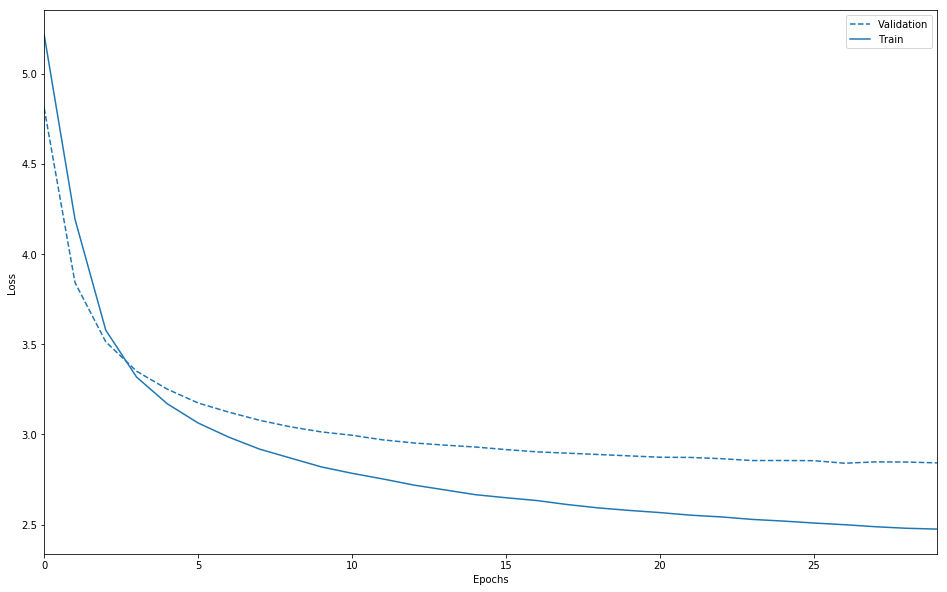

In [22]:
def plot_loss(history):
  plt.figure(figsize=(16,10))
  val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Validation')
  plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()

  plt.xlim([0,max(history.epoch)])

plot_loss(history)

## valiadation 선이 올라가는 시점이 오버피팅 => 가장 낮은시점이 학습 완료 시점

In [0]:
model = build_model(vocabulary_size, hidden_sizes[0], hidden_sizes, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 128)            69632     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (1, None, 128)            32896     
_________________________________________________________________
dense_1 (Dense)              (1, None, 544)            70176     
Total params: 172,704
Trainable params: 172,704
Non-trainable params: 0
_________________________________________________________________
None


![alt text](https://tensorflow.org/tutorials/sequences/images/text_generation_sampling.png)

In [0]:
# 다음단어 예측 모델

In [0]:
def generate_text(model):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 100

  # Converting our start string to numbers (vectorizing)
  start_token = np.random.randint(1, 100)
  print(reverse_dictionary[start_token], end='')
  input_eval = [start_token]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model.predict(input_eval, steps=1, use_multiprocessing=True)
      predicted_id = sample(predictions)
      predicted_id = np.squeeze(predicted_id)
      print(reverse_dictionary[predicted_id], end='')
    
      input_eval = tf.expand_dims([predicted_id], 0)
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      text_generated.append(reverse_dictionary[predicted_id])

  return (''.join(text_generated))

In [24]:
generate_text(model)

 come to the world, and the king's son was about the bird said, i will go out of the world, and the king's son was about the bird said, i will go out of the world, and the king's son was about the bird 

"ome to the world, and the king's son was about the bird said, i will go out of the world, and the king's son was about the bird said, i will go out of the world, and the king's son was about the bird "

In [0]:
,다음 and then 똑같은 문장 반복된다. lsm 쓰면 해결이 된다.